## Tips to speed up Python
[Luke Conibear](https://www.lukeconibear.com/)  
l.a.conibear@leeds.ac.uk  
23/02/2021  

- [Python is ...](#Python-is-...)
- [Hold on, before trying to speed things up …](#Hold-on,-before-trying-to-speed-things-up-…)
- [How fast is it and how much memory does it use?](#How-fast-is-it-and-how-much-memory-does-it-use?)
- [How fast could it go?](#How-fast-could-it-go?)
- [Potential improvements](#Potential-improvements)
  - [Append to lists, rather than concatenating](#Append-to-lists,-rather-than-concatenating)
  - [Move loop-invariants outside loops](#Move-loop-invariants-outside-loops)
  - [Use built−in functions](#Use-built−in-functions)
  - [Use suitable/optimal/specialised data structures](#Use-suitable/optimal/specialised-data-structures)
  - [Reduce repeated calculations with caching](#Reduce-repeated-calculations-with-caching)
  - [Use vectorisation instead of loops](#Use-vectorisation-instead-of-loops)
  - [Convert to compiled/static code](#Convert-to-compiled/static-code)
  - [Lazy loading and execution](#Lazy-loading-and-execution)
  - [Parallelisation](#Parallelisation)
    - [Single machine](#Single-machine)
    - [Multi-threading](#Multi-threading)
    - [Multi-processing](#Multi-processing)
    - [Interactive on HPC](#Interactive-on-HPC)
    - [HPC](#HPC)
  - [GPUs](#GPUs)
- [Recommendations](#Recommendations)
- [Further information](#Further-information)

### Python is ...
- High−level (abstracted away from computer, "executable pseudocode")
  - Clean, readable, and efficient API (Application Programming Interface i.e. the Python software, methods, classes, etc.).
  - Easy and fun to learn.
- Dynamic (no compilation)
  - Fast to write and test code.
  - Less code.
  - Flexible (interactive).
- Great support
  - Open source.
  - Vast range of libraries.
  - Huge number of users, including top software companies.
- Slow (often).
  - Because high-level and dynamic when using default CPython.

### Hold on, before trying to speed things up …
- Caution
  - Can optimise too early.
    - Trade-offs e.g. complexity, speed, memory, disk, readability, time, effort, etc.
  - Before optimisation:
    - Code is correct (tested, documented).
    - Optimisation is needed.
  - If optimisation is needed:
    - Simpler things first (e.g. data structures, algorithms, vectorisation).
    - Then more advanced ones (e.g. compilers, parallelisation, GPUs).
  - (CPU = central processing unit, IO = input output, RAM = random-access memory)

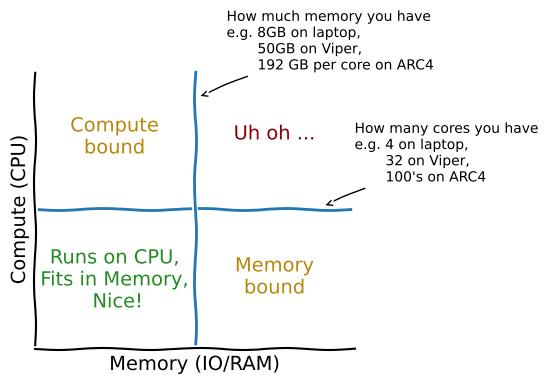

In [2]:
import matplotlib.pyplot as plt
import numpy as np

with plt.xkcd():
    fig = plt.figure(figsize=(4, 4), dpi=100)
    ax = fig.add_axes((0.1, 0.2, 0.8, 0.7))
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylim([0, 1])
    ax.set_xlim([0, 1])
    plt.axhline(y=0.5, linestyle='-')
    plt.axvline(x=0.5, linestyle='-')
    ax.annotate('Compute\nbound', xy=(0.25, 0.7), ha='center', color='darkgoldenrod')
    ax.annotate('Memory\nbound', xy=(0.75, 0.2), ha='center', color='darkgoldenrod')
    ax.annotate('Runs on CPU,\nFits in Memory,\n Nice!', xy=(0.25, 0.15), ha='center', color='forestgreen')
    ax.annotate('Uh oh ...', xy=(0.75, 0.75), ha='center', color='darkred')
    ax.annotate(
        "How many cores you have\ne.g. 4 on laptop,\n       32 on Viper,\n       100's on ARC4",
        arrowprops=dict(arrowstyle='->'),
        xy=(0.9, 0.51),
        xytext=(1, 0.6),
        fontsize=10
    )
    ax.annotate(
        "How much memory you have\ne.g. 8GB on laptop,\n       50GB on Viper,\n       192 GB per core on ARC4",
        arrowprops=dict(arrowstyle='->'),
        xy=(0.51, 0.9),
        xytext=(0.6, 1),
        fontsize=10
    )
    ax.set_xlabel('Memory (IO/RAM)')
    ax.set_ylabel('Compute (CPU)')
    plt.show()

### How fast is it and how much memory does it use?
- [Profiling](https://jakevdp.github.io/PythonDataScienceHandbook/01.07-timing-and-profiling.html)
  - [Speed](https://github.com/pyutils/line_profiler)
    - [IPython magic](https://jakevdp.github.io/PythonDataScienceHandbook/01.03-magic-commands.html) (Jupyter Lab)
      - Line: `%timeit`
      - Cell: `%%timeit`
      - If `pip install line_profiler`:
        - First load module: `%load_ext line_profiler`
        - Scripts: `%prun`
        - Line-by-line: `%lprun`
          - `@profile` decorator around the function
  - [Memory](https://github.com/pythonprofilers/memory_profiler)
    - If `pip install memory_profiler`:
    - First load module:
      - `%load_ext memory_profiler`
      - Line: `%memit`
      - Cell: `%%memit`
      - Line-by-line: `%mprun`

### How fast could it go?
- Time−space complexity (speed-memory)
  - [Big O notation](https://www.bigocheatsheet.com/).
  - Order of operations, O(...), (not the exact time of the operation).
  - Important for large number of elements (not for few).
  - Both separately for time and speed.
  - Can consider typical (often), worst (limiting, asymtopic), or best case scenario.
  - Ignores constants, so 2n + 1 would be O(n).
  - Takes largest order, so n<sup>2</sup> + n would be O(n<sup>2</sup>)
  - Constant time means per machine operation.
  - Identify what N is e.g. elements in array.
  - Could have multiple parameters e.g. O(n + m + k).

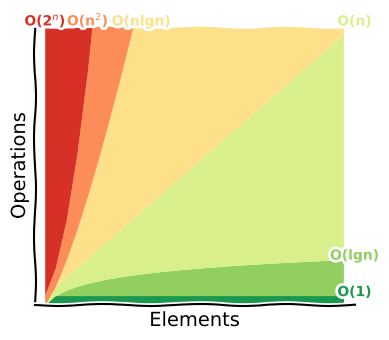

In [4]:
max_value = 30
elements = np.arange(1, max_value)

with plt.xkcd():
    fig = plt.figure(figsize=(4, 4), dpi=100)
    ax = fig.add_axes((0.1, 0.2, 0.8, 0.7))
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylim([0, max_value])
    ax.set_xlim([0, max_value])
    ax.set_xlabel('Elements')
    ax.set_ylabel('Operations')
    
    complexities = ['O(1)', 'O(lgn)', 'O(n)', 'O(nlgn)', 'O(n$^2$)', 'O(2$^n$)']
    colours = list(reversed(['#d73027', '#fc8d59', '#fee08b', '#d9ef8b', '#91cf60', '#1a9850']))
    x_values = [max_value, max_value, max_value, max_value / 3, max_value / 6, max_value / max_value]
    y_values = [max_value / max_value, np.log2(max_value), max_value, max_value, max_value, max_value]
    y_lows = [0, 1, np.log2(elements), elements, elements * np.log2(elements), elements ** 2]
    y_highs = [1, np.log2(elements), elements, elements * np.log2(elements), elements ** 2, max_value]
    
    for index, complexity in enumerate(complexities):
        plt.fill_between(elements, y_lows[index], y_highs[index], facecolor=colours[index])
        ax.annotate(complexity, xy=(x_values[index], y_values[index]), ha='center', color=colours[index], fontsize=10, weight='bold')
    
    plt.show()

### Potential improvements
*Reasons*

#### Append to lists, rather than concatenating
- *Because lists (dynamic arrays) are allocated twice the memory required, so appending fills this space up until size limit is reached - O(1) over long-term average (amortisation).*
- *While concatenating to them creates a new list each time - O(n).*

In [ ]:
%%timeit
my_list = []
for num in range(1_000):
    my_list += [num] # time O(n)

In [ ]:
%%timeit
my_list = []
for num in range(1_000):
    my_list.append(num) # time O(1)

#### Move loop-invariants outside loops
- *Quantities/calculations that don't vary with each cycle can be moved outside of the loop to avoid duplicating type-checking/calculations.*

In [ ]:
%%timeit
for num in range(1_000_000):
    constant = 500_000
    bigger_num = max(num, constant)

In [ ]:
%%timeit
constant = 500_000
for num in range(1_000_000):
    bigger_num = max(num, constant)

#### Use [built−in functions](https://docs.python.org/3/library/functions.html)
- *Optimised in [C](https://en.wikipedia.org/wiki/C_(programming_language) (statically typed and compiled).*

In [ ]:
nums = [num for num in range(1_000_000)]

In [ ]:
%%timeit
count = 0
for num in nums: # time O(n)
    count += 1

In [ ]:
%timeit len(nums) # time O(1)

#### Use suitable/optimal/specialised [data structures](https://docs.python.org/3/tutorial/datastructures.html)
- [Additional data structures](https://docs.python.org/3/library/collections.html).
- e.g. [tuples](https://docs.python.org/3/tutorial/datastructures.html#tuples-and-sequences) use less memory (than lists).
  - *Tuples are immutable (fixed), do not over-allocate, and do not have pointers.*
  - [Named-tuple](https://docs.python.org/3/library/collections.html#collections.namedtuple) variant with field attribute look-up.

In [ ]:
my_list  = [1, 2, 3]
my_tuple = (1, 2, 3)

In [ ]:
import sys

In [ ]:
sys.getsizeof(my_list)

In [ ]:
sys.getsizeof(my_tuple)

- e.g. [dictionaries](https://docs.python.org/3/tutorial/datastructures.html#dictionaries) use less time (than lists).
  - *Dictionaries (hash tables) hash keys (arrays) to values (linked lists).*
  - *Both keys and values can be any arbitrary objects.*
  - *The hashed keys are indexed and can be searched in O(1).*
  - Can use more memory (though [ordered dictionaries](https://docs.python.org/3/library/collections.html#collections.OrderedDict) are more memory efficient).

In [ ]:
import numpy as np

In [ ]:
haystack_list = np.random.uniform(low=0, high=100, size=(1_000_000))

haystack_dict = {key: value for key, value in enumerate(haystack_list)}

needles = [0.1, 50.1, 99.1]

In [ ]:
%%timeit
needles_found = 0
for needle in needles:
    if needle in haystack_list: # time O(n) within list
        needles_found += 1

In [ ]:
%%timeit
needles_found = 0
for needle in needles:
    if needle in haystack_dict: # time O(1) within dict
        needles_found += 1

- e.g. [sets](https://docs.python.org/3/tutorial/datastructures.html#sets) are fast for membership testing.
  - *Sets are hashed (unique), so hash can be found and object returned in O(1).*
  - Question: Find the first duplicated value in an array.
    - So, within the array [2, 1, 5, 2, 3, 3, 4], 2 and 3 and both duplicated, though 2 is the first duplicated value.

In [1]:
def first_duplicate_value_brute_force(array): # time O(n^2), space O(1)
    minimum_second_index = len(array)
    for index1 in range(len(array)):
        value = array[index1]
        for index2 in range(index1 + 1, len(array)):
            value_to_compare = array[index2]
            if value == value_to_compare:
                minimum_second_index = min(minimum_second_index, index2)
                
    if minimum_second_index == len(array):
        return -1
    
    return array[minimum_second_index]

In [5]:
%timeit first_duplicate_value_brute_force([2, 1, 5, 2, 3, 3, 4])

2.45 µs ± 9.8 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [3]:
def first_duplicate_value_set(array): # time O(n), space O(n)
    seen = set()
    for value in array:
        if value in seen:
            return value
        seen.add(value)
        
    return -1

In [6]:
%timeit first_duplicate_value_set([2, 1, 5, 2, 3, 3, 4])

354 ns ± 1.27 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


- Many more examples of trade-offs in specific data structures (e.g. generators save memory by yielding only the next iteration, 32 bit floats use less memory than 64 bit floats, etc.).

#### Reduce repeated calculations with [caching](https://realpython.com/lru-cache-python/)
- [Memoisation](https://en.wikipedia.org/wiki/Memoization)
- Example below is for the [Fibonacci sequence](https://en.wikipedia.org/wiki/Fibonacci_number), where each number is the sum of the two preceding ones starting from 0 and 1 e.g. 0, 1, 1, 2, 3, 5, 8, 13, 21, 34.
- *The brute force version of fibonacci takes O(2^n) time as there are 2 calls to the function n times (a balanced tree of repeated calls).*
- *The cached version of fibonacci takes O(n) time as there is 1 call to the function for each value of n.*
- *(Note the space complexity is O(n) in both cases, as recursion places n calls to the function on the call stack, also there is a dictionary of size n in the cached version).*

In [ ]:
def fibonacci(n):
    if n == 0 or n == 1:
        return 0
    elif n == 2:
        return 1
    
    return fibonacci(n - 1) + fibonacci(n - 2)

In [ ]:
%timeit fibonacci(20)

In [ ]:
def fibonacci_with_caching(n, cache={0: 0, 1: 0, 2: 1}):
    if n in cache:
        return cache[n]
    else:
        cache[n] = fibonacci_with_caching(n - 1, cache) + fibonacci_with_caching(n - 2, cache)
        return cache[n]

In [ ]:
%timeit fibonacci_with_caching(20, cache={0: 0, 1: 0, 2: 1})

#### Use [vectorisation](https://jakevdp.github.io/PythonDataScienceHandbook/02.03-computation-on-arrays-ufuncs.html) instead of loops
- Loops are slow in Python ([CPython](https://www.python.org/), default interpreter).
  - *Because loops type−check and dispatch functions per cycle.*
- [Vectors](https://en.wikipedia.org/wiki/Automatic_vectorization) can work on many parts of the problem at once.
- NumPy [ufuncs](https://numpy.org/doc/stable/reference/ufuncs.html) (universal functions).
  - *Optimised in C (statically typed and compiled).*

In [ ]:
nums = np.arange(1_000_000)

In [ ]:
%%timeit
for num in nums:
    num *= 2

In [ ]:
%%timeit
double_nums = np.multiply(nums, 2)

- [Broadcasting](https://jakevdp.github.io/PythonDataScienceHandbook/02.05-computation-on-arrays-broadcasting.html) (ufuncs over different shaped arrays, [NumPy](https://numpy.org/doc/stable/user/basics.broadcasting.html), [xarray](https://xarray.pydata.org/en/v0.16.2/computation.html?highlight=Broadcasting#broadcasting-by-dimension-name)).

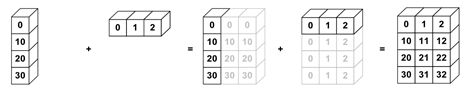

In [ ]:
nums_col = np.array([0, 10, 20, 30]).reshape(4, 1)
nums_row = np.array([0, 1, 2])

In [ ]:
nums_col + nums_row

In [ ]:
import xarray as xr

In [ ]:
nums_col = xr.DataArray([0, 10, 20, 30], [('col', [0, 10, 20, 30])])
nums_row = xr.DataArray([0, 1, 2], [('row', [0, 1, 2])])

In [ ]:
nums_col + nums_row

#### Algorithm improvements
- ...
- ...

- e.g. 


- e.g. ...

#### Convert to compiled/static code
- [PyPy](https://www.pypy.org/)
  - *Uses just−in−time compiler for all code that replaces CPython.*
  - *Approximately 4.2 times faster than CPython.*
- [Cython](https://cython.org/)
  - *Converts to static compiled C.*
- [Numba](http://numba.pydata.org/)
  - *Uses just-in-time compiler on functions via decorators.*
  - *Converts to fast machine code (LLVM).*
  - Good with NumPy, loops, and broadcasting.

In [ ]:
from numba import njit

In [ ]:
def super_function(nums):
    trace = 0.0
    for num in nums: # loop
        trace += np.cos(num) # numpy
    return nums + trace # broadcasting

In [ ]:
nums = np.arange(1_000_000)

In [ ]:
%timeit super_function(nums)

In [ ]:
@njit
def super_function(nums):
    trace = 0.0
    for num in nums: # loop
        trace += np.cos(num) # numpy
    return nums + trace # broadcasting

In [ ]:
%timeit super_function(nums)

#### [Lazy loading](https://xarray.pydata.org/en/v0.16.2/dask.html) and [execution](https://tutorial.dask.org/01x_lazy.html)
- Delays loading data into memory and/or executing commands until requested.
- Enables the handling of larger than memory files.
- Works well with parellisation (coming next).
- *Saves time by not having to continually handle large files.*
- [Video example for climate data](https://youtu.be/2rgD5AJsAbE).

In [ ]:
xr.tutorial.open_dataset('air_temperature')

In [ ]:
import dask.array as da

In [ ]:
%time
my_array = da.random.random((10_000, 10_000), chunks=(1_000, 1_000))
my_array

In [ ]:
%time
result = my_array + my_array.T
result

In [ ]:
%time result.compute()

#### Parallelisation
- Divide a large problem into many smaller ones and solve simultaneously.
  - *Divides up the time/space complexity.*
  - Multi-processing
    - Multiple processes (cores), CPU features, useful for compute-bound problems.
  - Multi-threading
    - Multiple threads (parts of processes), operating environment features, useful for memory-bound problems.
  - Asynchronous
    - Threads for massive scaling.
- How parallelisable is the code?
  - [Amdahl's law](https://en.wikipedia.org/wiki/Amdahl%27s_law) summarises the theoretical speed up factor from parallelising = 1 / (1 - amount_parallelisable)
  - e.g. if code (all in serial) takes 20 hours and 90% is parallelisable, then theoretical speed up factor = 1 / (1 - 0.90) = 10,  i.e. down to 2 hours (the time for the serial part).
  - e.g. if code (all in serial) takes 20 hours and 10% is parallelisable, then theoretical speed up factor = 1 / (1 - 0.10) = 1.1, i.e. down to 18 hours (the time for the serial part).
- If need to share memory across chunks
  - Use [shared memory](https://docs.dask.org/en/latest/shared.html)
  - `-pe smp np` on ARC4
  - Common framework is OpenMP (Open Multi-Processing)
  - Either multi-threading or multi-processing.
- Otherwise
  - Use [message passing interface, MPI](https://docs.dask.org/en/latest/setup/hpc.html?highlight=mpi#using-mpi)
  - `-pe ie np` on ARC4
  - Common framework is OpenMPI
  - Often multi-processing.

##### [Single machine](https://docs.dask.org/en/latest/setup/single-distributed.html)
- [Dask](https://docs.dask.org/en/latest/)
  - Simplifies parallelising Python code using familiar API.
- Viper example using [xarray](http://xarray.pydata.org/en/stable/dask.html)

In [ ]:
from IPython.display import Video

In [ ]:
Video('dask_single_machine.mp4')

In [ ]:
from dask.distributed import Client
client = Client()
client

In [ ]:
ds = xr.open_dataset(
    '/nfs/a68/shared/earlacoa/wrfout_2015_PM_2_DRY_0.25deg.nc',
    chunks={'time': 'auto'}
)

In [ ]:
ds.nbytes * (2 ** -30)

In [ ]:
%time ds_mean = ds.mean()

In [ ]:
%time ds_mean.compute()

In [ ]:
ds.close()
client.close()

##### Multi-threading
- e.g. [dask.array](https://examples.dask.org/array.html)
  - Similar to NumPy arrays / API.

In [ ]:
Video('multi-threading.mp4')

In [ ]:
from dask.distributed import Client
client = Client(
    processes=False,
    threads_per_worker=4,
    n_workers=1
)
client

In [ ]:
import dask.array as da

In [ ]:
my_array = da.random.random((50_000, 50_000), chunks=(5_000, 5_000))
result = my_array + my_array.T
result

In [ ]:
result.compute()

In [ ]:
client.close()

##### Multi-processing
- e.g. [dask.dataframe](https://examples.dask.org/dataframe.html)
  - Similar to Pandas dataframes / API.

In [ ]:
Video('multi-processing.mp4')

In [ ]:
from dask.distributed import Client
client = Client()
client

In [ ]:
import dask
import dask.dataframe as dd

In [ ]:
df = dask.datasets.timeseries()
df

In [ ]:
type(df)

In [ ]:
result = df.groupby('name').x.std()
result

In [ ]:
result.visualize()

In [ ]:
result_computed = result.compute()

In [ ]:
type(result_computed)

In [ ]:
client.close()

##### [Interactive on HPC](https://pangeo.io/setup_guides/hpc.html)
- e.g. [dask.bag](https://examples.dask.org/bag.html)
  - Iterators over a collection of independent objects.
  - Embarrassingly parallel.
- [Video instructions](https://youtu.be/FXsgmwpRExM).
  - Create or edit the `~/.config/dask/jobqueue.yaml` file with that in this directory.
  - Also, can check the `~/.config/dask/distributed.yaml` file with that in this directory.

In [ ]:
Video("interactive_on_hpc.mp4")

In [ ]:
# in a terminal

# log onto arc4
ssh ${USER}@arc4.leeds.ac.uk

# start an interactive session on a compute node on arc4
qlogin -l h_rt=04:00:00 -l h_vmem=12G

# activate your python environment
conda activate my_python_environment

# echo back the ssh command to connect to this compute node
echo "ssh -N -L 5555:`hostname`:5555 -L 5757:`hostname`:5757 ${USER}@arc4.leeds.ac.uk"

# launch a jupyter lab session on this compute node
jupyter lab --no-browser --ip=`hostname` --port=5555

In [ ]:
# in a local terminal
# ssh into the compute node
ssh -N -L 5555:`hostname`:5555 -L 5757:`hostname`:5757 ${USER}@arc4.leeds.ac.uk

In [ ]:
# open up a local browser (e.g. chrome)
# go to the jupyter lab session by pasting into the url bar
localhost:5555
    
# can also load the dask dashboard in the browser at localhost:5757

In [ ]:
# now the jupyter code
from dask_jobqueue import SGECluster
from dask.distributed import Client

cluster = Client(
    walltime='01:00:00',
    memory='4 G',
    resource_spec='h_vmem=4G',
    scheduler_options={
        'dashboard_address': ':5757',
    },
)

client = Client(cluster)

In [ ]:
cluster.scale(jobs=20)

In [ ]:
client

In [ ]:
import numpy as np
import dask.bag as db

In [ ]:
nums = np.random.randint(low=0, high=100, size=(5_000_000))
nums

In [ ]:
def weird_function(nums):
    return chr(nums)

In [ ]:
bag = db.from_sequence(nums)
bag = bag.map(weird_function)
bag.visualize()

In [ ]:
result = bag.compute()

In [ ]:
client.close()
cluster.close()

##### [HPC](https://docs.dask.org/en/latest/setup/hpc.html)
- Non-interactive.
- Create/edit the `dask_on_hpc.py` file.
- Submit to the queue using `qsub dask_on_hpc.bash`.

#### GPUs
- Graphics Processing Units.
- *Faster than CPUs as specifically optimised for numerical operations, while CPUs perform general computation.*
- Not for IO-bound problems.
- [cuPy](https://cupy.dev/).
  - Works well with NumPy, similar API.
- [cuDF](https://docs.rapids.ai/api/cudf/stable/).
  - Works well with Pandas, similar API.
```python
import cupy as cp
x = cp.arange(6).reshape(2, 3).astype('f')
x.sum(axis=1)
```
- Can run in [parallel](https://docs.dask.org/en/latest/gpu.html).
  - GPUs available on [ARC4](https://arcdocs.leeds.ac.uk/systems/arc4.html#using-the-v100-gpu-nodes).

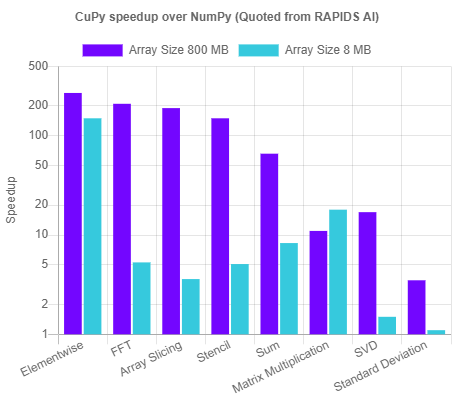

### Recommendations
Once code is correct and optimisation is needed:
1. Profile your code to find what takes up the most time / memory.
  - Within a cell in Jupyter Lab: `%%timeit` and `%%memit`.
  - Line-by-line over a function to find the bottleneck: `line_profiler`, `@profile` decorator, and `%lprun`.
2. First, try simpler optimisations:
    - Use the optimal data structures for your problem.
    - Use existing libraries when can that are already optimised (computationally and algorithmically).
    - Use broadcasting/vectorisation (instead of loops where can).
    - Lazy loading and execution.
3. Then, if needed, more advanced optimisations:
    - Statically type and compile functions with Numba.
    - Parallelise suitable and large problems.
      - Use multi-processing with OpenMPI.
        - *Simpler than multi-threading (as don't need to worry about [Global Interpreter Lock, GIL](https://wiki.python.org/moin/GlobalInterpreterLock)).*
      - Use Dask:
        - *Great documentation.*
        - *Under the hood for many libraries e.g. xarray, iris, scikit-learn.*
        - *Swap out for Numpy arrays or Pandas DataFrames.*
        - *[Coiled](https://coiled.io/about/) is a spin-off for increasing access to Dask.*
      - Use embarrassingly parallel code for independent problems (e.g. dask.bag).
      - Use interactively via Jupyter Lab on a HPC.

### Further information
- [Anthony Shaw - Why is Python slow?](https://youtu.be/I4nkgJdVZFA), PyCon 2020. CPython Internals [book](https://realpython.com/products/cpython-internals-book/).
- [Pangeo](https://pangeo.io/index.html) - Python libraries that work well together and build on each other, especially for big data geosciences (e.g. NumPy, Pandas, xarray, iris, Dask, Numba, Jupyter).
- Luciano Ramalho, [*Fluent Python, Clear, Concise, and Effective Programming*](https://www.oreilly.com/library/view/fluent-python/9781491946237/), 2015. O'Reilly Media, Inc.
- Jake VanderPlas, [*Python Data Science Handbook*](https://www.oreilly.com/library/view/python-data-science/9781491912126/), 2016. O'Reilly Media, Inc.